## **To recreate study results please load package versions found in main_requirements.txt**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os

# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.6.0 anndata==0.7.4 umap==0.4.3 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.0


In [2]:
import warnings
warnings.simplefilter( action="ignore", category=FutureWarning)

In [3]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc

## **Load log2 CPM pseudo-bulk and GAM fit data pickles**

In [4]:
# load log2 TMM pseudo-bulked data from limma-voom
# logTMMs.pkl was saved in 11__dev-DEGs_age-trend-fits_rate-of-change.ipynb
logTMMs = nmc.load_obj( "../data/logTMMs.pkl")
# GAM fits from 12__major-trajectory_dev-DEGs_stage-trend-fits.ipynb
good_fits = nmc.load_obj( f"../data/STAGE_gam_fits_12_grid100.pkl")

In [5]:
# read in anndata for obs
adata = sc.read_h5ad( "../data/post-gaba-wt-dev-traj.h5ad")
obs_df = adata.obs.copy()
# clean up dataframe by dropping all duplicates of batch entries
obs_df.drop_duplicates( subset='batch', keep="first", inplace=True)

## Read in GO terms from maturation DEGs for each major cluster

In [6]:
mat_degs = nmc.load_obj( "../data/devDEG_Gene-Ontology-hits.pkl")
mat_degs.keys()

dict_keys(['Astro', 'ID2', 'L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4', 'LAMP5_NOS1', 'Micro', 'Oligo', 'OPC', 'PV', 'PV_SCUBE3', 'SST', 'VIP'])

In [7]:
counts = {}
for k_itr, v_itr in mat_degs.items():
    if( k_itr=='Micro'):
        continue
    print( k_itr)
    words = v_itr['name'].values
    for word in words:
        counts[word] = counts.get(word, 0) + 1
        
pairs = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
sorted_terms = []
for itr, (word, count) in enumerate( pairs):
    if( count>=0):
        sorted_terms.append( f"{word}__{count}")
#     print(word, count)

Astro
ID2
L2-3_CUX2
L4_RORB
L5-6_THEMIS
L5-6_TLE4
LAMP5_NOS1
Oligo
OPC
PV
PV_SCUBE3
SST
VIP


In [8]:
def search_term( term, sorted_terms=sorted_terms):
    return( [ii for ii in sorted_terms if term in ii])

In [9]:
# one_offs_dict['L4_RORB']

### Plot GO terms

In [10]:
go_file_bp = "/scratchfs/cherring/brain_maturation/analysis/first_final_notebooks/maturation_dynamics/new_single_GAM-fit/data/GO_genes_ref_data/hsapiens.GO:BP.name.gmt"
go_file_mf = "/scratchfs/cherring/brain_maturation/analysis/first_final_notebooks/maturation_dynamics/new_single_GAM-fit/data/GO_genes_ref_data/hsapiens.GO:MF.name.gmt"

In [11]:
import csv
GO_terms = {}
with open( go_file_bp, 'r') as f:
    reader = csv.reader( f, delimiter='\t')
    for row in reader:
#         print( row[2:])
        GO_terms[row[1]] = np.array( row[2:])
with open( go_file_mf, 'r') as f:
    reader = csv.reader( f, delimiter='\t')
    for row in reader:
#         print( row[2:])
        GO_terms[row[1]] = np.array( row[2:])

## Plot some GO terms - mean expression over stages

In [12]:
color_dict = adata.uns['major_clust_colors_dict']

In [13]:
mj_plot_order = adata.uns['major_clust_plot_order'].tolist()

### Based on prior knowledge lets clean up the data a bit

PN neurons are largely post mitotic and have migrated to cortical layers by ga22, so removing any PN with a DEG for migration. The positive hit for migration in PNs could be due to the large overlap of genes in migration and dendrite/axon growth. 

In [14]:
pns = ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4']
for ii in pns:
    if( np.any( mat_degs[ii]['name']=='cell migration')):
        print(ii)
        mat_degs[ii] = mat_degs[ii].loc[~(mat_degs[ii]['name']=='cell migration').values,:]

L2-3_CUX2
L4_RORB
L5-6_THEMIS
L5-6_TLE4


In [15]:
for ii in pns:
    if( np.any( mat_degs[ii]['name']=='neuron migration')):
        print(ii)
        mat_degs[ii] = mat_degs[ii].loc[~(mat_degs[ii]['name']=='neuron migration').values,:]

L2-3_CUX2
L4_RORB
L5-6_THEMIS
L5-6_TLE4


## Eigenvalues of gene trends

In [16]:
# quantile norm by all trends
df = pd.concat( list( good_fits.values()), keys=list(good_fits.keys()))
df.index.names = ['cell_type','gene']
rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
all_quant_df = df.rank(method='min').stack().astype(int).map(rank_mean).unstack()
# re-combine into a dict
quant_fits_dict = {}
for key in good_fits.keys():
    print( key)
    quant_fits_dict[key] = all_quant_df.loc[key]

Astro
ID2
L2-3_CUX2
L4_RORB
L5-6_THEMIS
L5-6_TLE4
LAMP5_NOS1
Micro
Oligo
OPC
PV
PV_SCUBE3
SST
VIP


In [17]:
# quant norm before PCA
def eigen_val( go_term, clust_nm, logTMMs=logTMMs, GO_terms=GO_terms, good_fits=quant_fits_dict):
    inter_genes = np.intersect1d( GO_terms[go_term], logTMMs[clust_nm].index)
    # get df with just trends of intersect genes
    trend_df = good_fits[clust_nm].loc[inter_genes]
    # this will return a matrix with rows as time and cols as genes
    tt = trend_df.T
    # Get prinicple components
    go_pcs = sc.pp.pca( tt, n_comps=2, zero_center=False)
    return( go_pcs[:,0])

In [18]:
goes = ['neuron migration', 'neuron projection development', 'synapse organization', 'apoptotic process', 
        'learning or memory', 'ensheathment of neurons', 'ion transport']

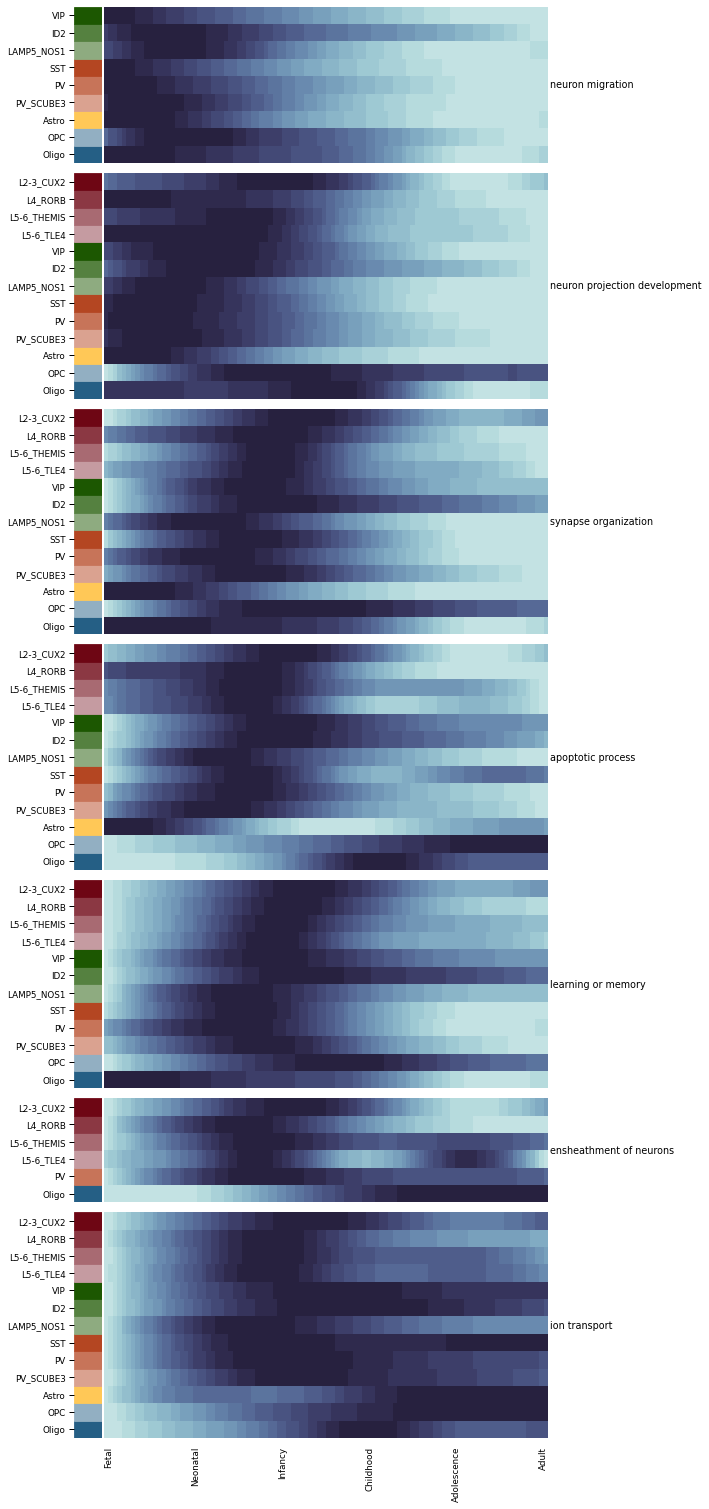

In [20]:
import matplotlib.patches as patches
# There is an annoying ImplicitModificationWarning from anndata that is baked into running scanpy PCA with a non-anndata object. 
# It is thrown repeatedly with this code so I have suppressed warnings. Plot with generate without issue otherwise. 
import warnings
warnings.filterwarnings('ignore')

n_grid_pts = 100
stage_order = adata.uns['stage_order']
num_stages = len(stage_order)
# get list of cluster hit for each go term
go_celltypes_dict = {}
for gg in goes:
    go_celltypes = []
    for kk, vv in mat_degs.items():
        search_itr = search_term( gg, sorted_terms=vv['name'].values)
        search_mk = [ii==gg for ii in search_itr]
        if( np.any( search_mk)):
            go_celltypes.append(kk)
    # re-order cell types to match paper ordering
    Y = [mj_plot_order.index(ii) for ii in go_celltypes]
    X = go_celltypes
    go_celltypes_dict[gg] = [x for _,x in sorted(zip(Y,X))]
# color scale for expression
cmap = sns.color_palette( "ch:start=.2,rot=-.3", n_colors=20)

# create figure with subplots
n = len( goes)
widths = [0.5,8]
heights = [len(ii) for ii in go_celltypes_dict.values()]
fig = plt.figure( constrained_layout=False, figsize=(sum(widths),sum(heights)/3))
spec = fig.add_gridspec( ncols=2, nrows=n, width_ratios=widths,
                          height_ratios=heights)
spec.update( wspace=0.01, hspace=0.05)

plot_vals_dict = {}
# loop through goes to get average expression
for itr, (go_itr, glc_itr) in enumerate( zip( goes, goes)):
    ax = fig.add_subplot( spec[itr,1])
    df_itr = pd.DataFrame( [], columns=good_fits['L2-3_CUX2'].columns.values, index=go_celltypes_dict[glc_itr], dtype=float)
    # get average trend expression
    for key_itr in go_celltypes_dict[glc_itr]:
        # get eigen value
        df_itr.loc[key_itr] = eigen_val( glc_itr, key_itr)
#         df_itr.loc[key_itr] = trends_avg( GO_terms[go_itr], good_fits[key_itr])
        # normalize rows 0 to 1
        df_itr = df_itr.subtract(df_itr.min(axis=1), axis=0)\
          .divide(df_itr.max(axis=1) - df_itr.min(axis=1), axis=0)\
          .combine_first(df_itr)
    plot_vals_dict[glc_itr] = df_itr
    ### right plot
    cg = sns.heatmap( df_itr, ax=ax, cmap=cmap, xticklabels=False, yticklabels=False, cbar=False)
#     cg.set_title( go_itr, loc='right')
    # remove ticks for subplots
    cg.tick_params( bottom=False)
    # rotate y labels
    plt.setp( cg.yaxis.get_majorticklabels(), rotation=0)
    go_title = go_itr
    ax.text( 1.005, 0.50, go_title, transform=ax.transAxes, ha='left', va='center')
ticks = np.linspace( 1.0, n_grid_pts-1.0, num_stages)
ax.set_xticks( ticks)
ax.set_xticklabels( stage_order, rotation=90);
### left plot
# add color blocks for each major-cluster
for itr, glc_itr in enumerate( goes):
    ax = fig.add_subplot( spec[itr,0])
    cell_list = go_celltypes_dict[glc_itr]
    for i, cell_itr in enumerate( cell_list[::-1]):
        yy = 1 * i
        # Create a Rectangle patch
        rect = patches.Rectangle((0.0,yy), 0.5, 1.0, color=color_dict[cell_itr])
        # Add the patch to the Axes
        ax.add_patch(rect)
    ax.set_xlim(0,0.5)
    ax.set_ylim(0,len(cell_list))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticklabels( cell_list[::-1])
    ax.set_yticks( np.linspace(0.5, len(cell_list)-0.5, len(cell_list)))
# plt.savefig( f"/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/out_figs/dynamic-GO-terms_mj-clusts_splines{n_splines}_grids{n_grid_pts}.svg", format='svg', bbox_inches='tight')

## Statistical Testing Plots

In [54]:
out_path = "../data/"

In [55]:
num_cuts = np.array( [0,20,40,60,80,100])
arc_cuts = num_cuts#np.arcsinh( num_cuts / 0.55) #whole_adata2.uns['arcsinh_cofact'])
age_cuts = stage_order

In [56]:
import matplotlib as mpl
from matplotlib import cm

def plot_color_bar( x1, x2):
    sort_arcages = arc_cuts
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.80, 0.05])
    viridis = cm.get_cmap('viridis', 256)
    cb = mpl.colorbar.ColorbarBase( ax, orientation='horizontal', cmap=viridis, 
                                    norm=mpl.colors.Normalize(0,100),
                                    ticks=sort_arcages)
    cb.set_ticklabels( age_cuts) #age_order);
    ax.set_xticklabels( age_cuts, rotation='vertical')
    ax.xaxis.set_ticks_position('top')
    ax.vlines( x1, 0, 100, colors='Red', linewidth=3.0);
    ax.vlines( x2, 0, 100, colors='Red', linewidth=3.0);
#     ax.arrow( x1, 50, x2-x1, 0.1, head_width=0.5, head_length=0.3, linewidth=3, color='Red', length_includes_head=True)
    ax.annotate( s='', xy=(x1,50), xytext=(x2,50), arrowprops=dict(arrowstyle='<-', color='Red'))
    return(ax)

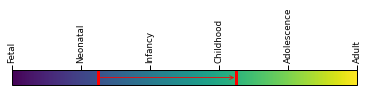

In [57]:
plot_color_bar( 25,65)

## Wilcoxon Testing of Eigentrends

In [58]:
from scipy.stats import wilcoxon
sns.set_theme(context="paper",font_scale=1.75)

In [59]:
def wilco( go, rr, tt, rs1, ts1, rs2=100, ts2=100, pvd=plot_vals_dict, alt="greater"):
    df = pvd[go]
    x = df.loc[rr].values[rs1:rs2]
    y = df.loc[tt].values[ts1:ts2]
    return( wilcoxon( x, y, zero_method='pratt', alternative=alt)[1])

In [60]:
def loop_wilco( ref, test, go, r_start, t_start, r_stop, t_stop):
    df = pd.DataFrame( [], index=[ref], columns=test, dtype=float)
    p_max = -999999
    for tt in test:
        wil_res = wilco( go, ref, tt, r_start, t_start, rs2=r_stop, ts2=t_stop)
        df.loc[ref,tt] = wil_res
        if p_max<wil_res:
            p_max = wil_res
        print( f"{ref} vs {tt} = {wil_res} ...sig={wil_res<0.05}")
    print( p_max)
    return( df)

In [61]:
#left, bottom, width, height
def cluster_map( df, go):
    ax = sns.clustermap( data=df, row_cluster=False, col_cluster=False,
                        row_colors=[color_dict[ii] for ii in df.index],
                        col_colors=[color_dict[ii] for ii in df.columns],
                        colors_ratio=(0.02,0.2),
                        dendrogram_ratio=(0.01,0.1),
                        cbar_pos=(0.045, 0.001, 0.92, 0.05), 
                        cbar_kws={"orientation":"horizontal"},
                        figsize=(2*len(test),2),
                        annot=True, cmap='Reds', linewidths=0.2);
    plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
    # ax.ax_cbar.set_title('p-values')
    ax.ax_heatmap.xaxis.set_label_position('top')
    ax.fig.suptitle(f"{go} pvalues");
    ax.fig.savefig( out_path+f"heatmap_{go}_{df.index.values}.svg", format='svg', bbox_inches='tight')
    return

"Notably, ID2 INs show expression through to adulthood (Fig. 2E), suggesting that ID2 INs undergo extended migration into infancy and beyond."

In [67]:
go = 'neuron migration'
ref = 'ID2'
test = plot_vals_dict[go].index
test = test[test!=ref]
df = loop_wilco( ref=ref,
            test=test,
            go=go,
            r_start=40, r_stop=100,
            t_start=40, t_stop=100)

ID2 vs VIP = 8.570746990858083e-12 ...sig=True
ID2 vs LAMP5_CA1 = 1.819456954256536e-11 ...sig=True
ID2 vs SST = 8.354023216054315e-12 ...sig=True
ID2 vs PV = 8.354023216054315e-12 ...sig=True
ID2 vs PV_SCUBE3 = 8.354023216054315e-12 ...sig=True
ID2 vs Astro = 1.4902864511822716e-11 ...sig=True
ID2 vs OPC = 0.0037257677960571105 ...sig=True
ID2 vs Oligo = 0.001578600321070996 ...sig=True
0.0037257677960571105


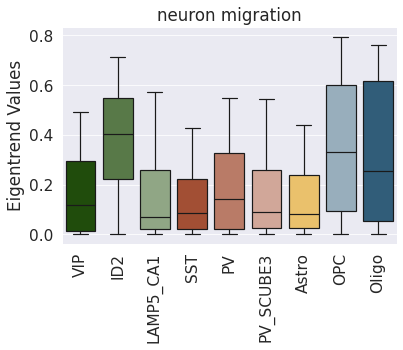

In [68]:
ax = sns.boxplot( data=plot_vals_dict[go].iloc[:,40:100].T, palette=color_dict);
plt.setp(ax.get_xticklabels(), rotation=90);
ax.set_title(f"{go}")
ax.set_ylabel('Eigentrend Values')
ax.figure.savefig( out_path+f"barplot_{go}_{ref}.svg", format='svg', bbox_inches='tight')

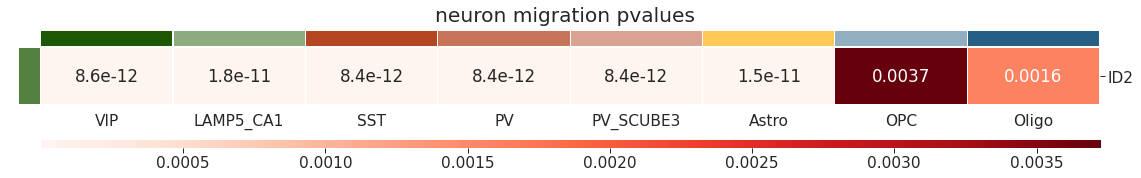

In [69]:
cluster_map( df, go)

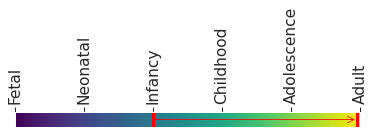

In [70]:
ax = plot_color_bar( 40, 99)
ax.figure.savefig( out_path+f"colorbar_{go}_{df.index.values}.svg", format='svg', bbox_inches='tight')

"The eigentrend for “neuron projection development” suggests peak dendritic growth continues into childhood for deeper layer PNs with delayed dendritic growth again seen for VIP/ID2 INs"

In [71]:
go = 'neuron projection development'
ref = 'ID2'
test = plot_vals_dict[go].index
test = test[test!=ref]
df1 = loop_wilco( ref=ref,
            test=test,
            go=go,
            r_start=40, r_stop=100,
            t_start=40, t_stop=100)

ID2 vs L2-3_CUX2 = 0.7845614168565139 ...sig=False
ID2 vs L4_RORB = 8.354023216054315e-12 ...sig=True
ID2 vs L5-6_THEMIS = 6.196188022879488e-09 ...sig=True
ID2 vs L5-6_TLE4 = 2.6567561152792056e-10 ...sig=True
ID2 vs VIP = 8.925908718976533e-09 ...sig=True
ID2 vs LAMP5_CA1 = 9.015193154818344e-12 ...sig=True
ID2 vs SST = 8.354023216054315e-12 ...sig=True
ID2 vs PV = 8.354023216054315e-12 ...sig=True
ID2 vs PV_SCUBE3 = 8.354023216054315e-12 ...sig=True
ID2 vs Astro = 1.2824001381314157e-11 ...sig=True
ID2 vs OPC = 0.9999999999918522 ...sig=False
ID2 vs Oligo = 0.9996458387843469 ...sig=False
0.9999999999918522


In [72]:
go = 'neuron projection development'
ref = 'VIP'
test = plot_vals_dict[go].index
test = test[test!=ref]
df2 = loop_wilco( ref=ref,
            test=test,
            go=go,
            r_start=45, r_stop=70,
            t_start=45, t_stop=70)

VIP vs L2-3_CUX2 = 0.9999938548388949 ...sig=False
VIP vs L4_RORB = 7.85255000987501e-06 ...sig=True
VIP vs L5-6_THEMIS = 1.1284095314026846e-05 ...sig=True
VIP vs L5-6_TLE4 = 6.1451611051242046e-06 ...sig=True
VIP vs ID2 = 0.9985265042728344 ...sig=False
VIP vs LAMP5_CA1 = 6.1451611051242046e-06 ...sig=True
VIP vs SST = 6.1451611051242046e-06 ...sig=True
VIP vs PV = 6.1451611051242046e-06 ...sig=True
VIP vs PV_SCUBE3 = 6.1451611051242046e-06 ...sig=True
VIP vs Astro = 6.1451611051242046e-06 ...sig=True
VIP vs OPC = 0.9999938548388949 ...sig=False
VIP vs Oligo = 0.9999938548388949 ...sig=False
0.9999938548388949


In [73]:
df = pd.concat( [df1,df2])

In [109]:

def cluster_map( df, go):
    ax = sns.clustermap( data=df, row_cluster=False, col_cluster=False,
                        row_colors=[color_dict[ii] for ii in df.index],
                        col_colors=[color_dict[ii] for ii in df.columns],
                        colors_ratio=(0.02,0.2),
                        dendrogram_ratio=(0.01,0.1),
                        #left, bottom, width, height
                        cbar_pos=(0.225, 0.001, 0.7, 0.05), 
                        cbar_kws={"orientation":"horizontal"},
                        figsize=(2*len(test),2),
                        annot=True, cmap='Reds', linewidths=0.2);
    plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
    # ax.ax_cbar.set_title('p-values')
    ax.ax_heatmap.xaxis.set_label_position('top')
    ax.fig.suptitle(f"{go} pvalues");
    ax.fig.savefig( out_path+f"heatmap_{go}_{df.index.values}.svg", format='svg', bbox_inches='tight')
    return

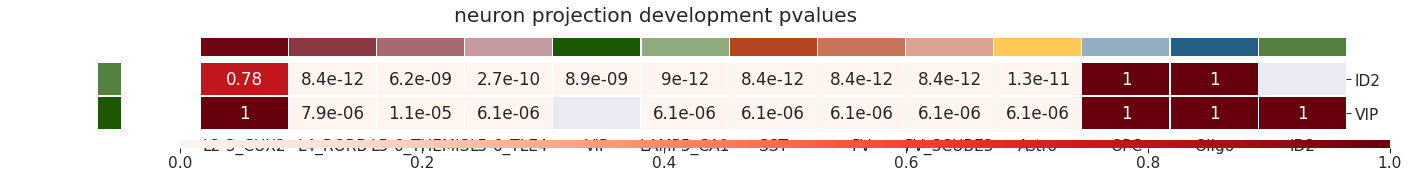

In [110]:
cluster_map( df, go)

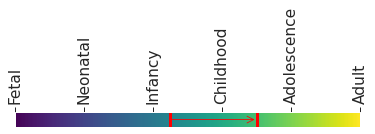

In [111]:
ax = plot_color_bar( 45, 70)
ax.figure.savefig( out_path+f"colorbar_{go}_{df.index.values}.svg", format='svg', bbox_inches='tight')

"Two distinct programs of neuron projection development, depending on local or global circuit connections, were evident in PN eigentrend (Fig. 2E). L4-RORB and L5/6-TLE4 neuron eigentrend peaks in fetal development, coinciding with known timing of thalamic axons reaching the cortical plate of the neocortex and forming early sensory-related circuits, as determined by neuroimaging studies (29, 30). In contrast, L2/3-CUX2 and L5/6-THEMIS showed highest eigentrend values after birth, suggesting that local projections become more concentrated at this time (29)."

In [144]:
plot_vals_dict[go].index.values

array(['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4', 'VIP', 'ID2',
       'LAMP5_CA1', 'SST', 'PV', 'PV_SCUBE3', 'Astro', 'OPC', 'Oligo'],
      dtype=object)

In [145]:
loop_wilco( ref='L4_RORB',
        test=['L2-3_CUX2','L5-6_THEMIS','L5-6_TLE4'],
        go='neuron projection development',
        r_start=0, r_stop=20,
        t_start=0, t_stop=20)

L4_RORB vs L2-3_CUX2 = 4.428728843931774e-05 ...sig=True
L4_RORB vs L5-6_THEMIS = 4.428728843931774e-05 ...sig=True
L4_RORB vs L5-6_TLE4 = 0.6455473452623182 ...sig=False
0.6455473452623182


In [146]:
loop_wilco( ref='L5-6_TLE4',
        test=['L2-3_CUX2','L5-6_THEMIS','L4_RORB'],
        go='neuron projection development',
        r_start=0, r_stop=20,
        t_start=0, t_stop=20)

L5-6_TLE4 vs L2-3_CUX2 = 4.428728843931774e-05 ...sig=True
L5-6_TLE4 vs L5-6_THEMIS = 4.428728843931774e-05 ...sig=True
L5-6_TLE4 vs L4_RORB = 0.3544526547376819 ...sig=False
0.3544526547376819


In [148]:
loop_wilco( ref='L2-3_CUX2',
        test=['L4_RORB','L5-6_TLE4','L5-6_THEMIS'],
        go='neuron projection development',
        r_start=20, r_stop=60,
        t_start=20, t_stop=60)

L2-3_CUX2 vs L4_RORB = 1.4514620977608931e-06 ...sig=True
L2-3_CUX2 vs L5-6_TLE4 = 0.0009092378739857393 ...sig=True
L2-3_CUX2 vs L5-6_THEMIS = 0.0011918244923356032 ...sig=True
0.0011918244923356032


In [149]:
loop_wilco( ref='L5-6_THEMIS',
        test=['L4_RORB','L5-6_TLE4','L2-3_CUX2'],
        go='neuron projection development',
        r_start=20, r_stop=60,
        t_start=20, t_stop=60)

L5-6_THEMIS vs L4_RORB = 4.8853458907770425e-06 ...sig=True
L5-6_THEMIS vs L5-6_TLE4 = 0.0007565841381471061 ...sig=True
L5-6_THEMIS vs L2-3_CUX2 = 0.9988081755076644 ...sig=False
0.9988081755076644
